In [1]:
#import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Cleaned_nova_pay_data.csv to Cleaned_nova_pay_data (2).csv


In [3]:
#read the data
nova_pay = pd.read_csv('Cleaned_nova_pay_data.csv')
nova_pay.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,hour,day,dayofweek,is_night
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,0,0.223,0,0,0.0,0,18,3,0,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,Web,208.51,154.29,4.24,...,0,0.268,0,1,0.0,0,20,3,0,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,Mobile,160.33,160.33,2.70,...,0,0.176,0,0,0.0,0,23,3,0,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,Mobile,59.41,59.41,2.22,...,0,0.391,0,0,0.0,0,1,4,1,1
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,Mobile,200.96,200.96,3.61,...,0,0.257,0,0,0.0,0,9,4,1,0


##**FEATURE ENGINEERING**

## Transaction behavior indicators

In [19]:
# Transaction amount ratios
nova_pay['amount_to_fee_ratio'] = nova_pay['amount_usd'] / (nova_pay['fee'] + 1e-6)  # avoid div by zero

# High-risk corridors (already exists), we can create a binary
nova_pay['high_corridor_risk'] = (nova_pay['corridor_risk'] > 0).astype(int)

# Device-based indicators
nova_pay['new_device_flag'] = nova_pay['new_device'].astype(int)

# IP & location mismatch
nova_pay['location_mismatch_flag'] = nova_pay['location_mismatch'].astype(int)

These features are important to  because it explains:

High amount-to-fee ratios can indicate unusual or risky transactions.

New devices or mismatched locations often flag suspicious activity.

High-risk corridors (cross-border transactions) are historically more prone to fraud.

## Customer-level patterns

In [20]:
# Aggregations by customer_id
customer_agg = nova_pay.groupby('customer_id').agg(
    cust_avg_amount=('amount_usd', 'mean'),
    cust_txn_count=('transaction_id', 'count'),
    cust_avg_velocity_1h=('txn_velocity_1h', 'mean'),
    cust_avg_velocity_24h=('txn_velocity_24h', 'mean'),
    cust_chargeback_count=('chargeback_history_count', 'sum')
).reset_index()


Transactions that deviate from the customer’s historical behavior are more likely to be fraudulent.

Customers with frequent past chargebacks or unusual velocities are at higher risk.

Amount per account age detects unusually large transactions relative to account tenure.

In [21]:
nova_pay = nova_pay.merge(customer_agg, on='customer_id', how='left')
nova_pay.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,cust_avg_amount_x,cust_txn_count_x,cust_avg_velocity_1h_x,cust_avg_velocity_24h_x,cust_chargeback_count_x,cust_avg_amount_y,cust_txn_count_y,cust_avg_velocity_1h_y,cust_avg_velocity_24h_y,cust_chargeback_count_y
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,369.421473,1500,0.119333,0.202000,0,369.421473,1500,0.119333,0.202000,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,Web,208.51,154.29,4.24,...,320.420950,358,0.131285,0.268156,0,320.420950,358,0.131285,0.268156,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,Mobile,160.33,160.33,2.70,...,388.536978,1059,0.124646,0.218130,0,388.536978,1059,0.124646,0.218130,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,Mobile,59.41,59.41,2.22,...,449.840657,807,0.101611,0.234201,0,449.840657,807,0.101611,0.234201,0
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,Mobile,200.96,200.96,3.61,...,393.995037,675,0.167407,0.287407,0,393.995037,675,0.167407,0.287407,0


## **DATA PREPROCESSING**

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import shap
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
import joblib

In [23]:
# Drop  unnecessary columns and set the feature and target
drop_cols = ['transaction_id', 'customer_id', 'timestamp', 'device_id', 'ip_address']
X = nova_pay.drop(columns=drop_cols + ['is_fraud'])
y = nova_pay['is_fraud']


In [24]:
# Encode categorical columns
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## **XGBoost Model**

In [43]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Compute scale_pos_weight
# scale_pos_weight = (# of negative samples) / (# of positive samples)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,               # reduce depth
    learning_rate=0.1,         # shrinkage
    subsample=0.8,             # row sampling
    colsample_bytree=0.8,      # feature sampling
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:,1]

# Evaluation
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:32:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1989
           1       0.07      0.03      0.04        39

    accuracy                           0.97      2028
   macro avg       0.53      0.51      0.51      2028
weighted avg       0.96      0.97      0.97      2028

Test ROC-AUC: 0.6890074899124673


**Interpretation:**

Accuracy = 97% -Looks high at first glance, but this is misleading because the dataset is extremely imbalanced. Most of the samples (1989/2028) are non-fraud (class 0). The model can predict almost everything as class 0 and still achieve very high accuracy.

F1-score / Recall / Precision for class 1 (fraud) are extremely low

F1 = 0.04, Recall = 0.03, Precision = 0.07

This means the model almost never detects fraud cases. Out of 39 fraud samples, it only correctly identifies 1–2.

ROC-AUC = 0.689 - This is better than random (0.5), meaning the model ranks fraud higher than non-fraud somewhat, but the default threshold (0.5) fails to classify positive cases properly.

Macro avg F1 = 0.51 vs weighted avg F1 = 0.97

Weighted avg is dominated by the majority class (non-fraud), which inflates the metric.

Macro avg shows the true performance across both classes, which is poor.

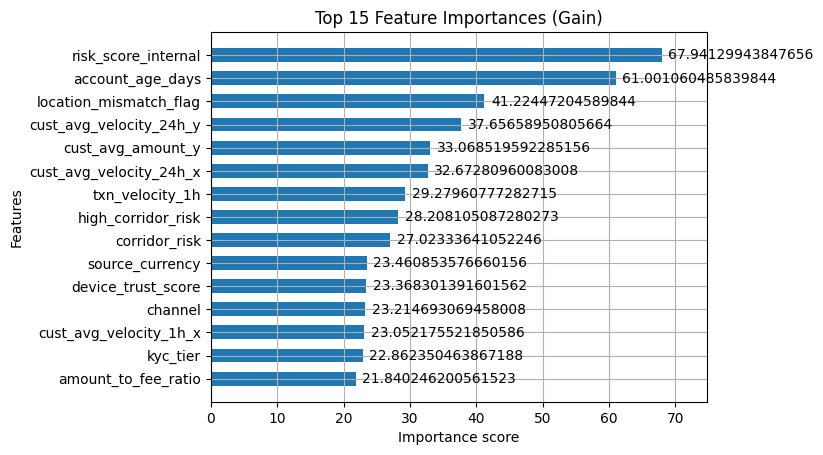

In [46]:
# Feature importance

xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain', height=0.6)
plt.title("Top 15 Feature Importances (Gain)")
plt.show()

## **Random Forest**

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize model with class weight and regularization
rf_model = RandomForestClassifier(
    n_estimators=200,        # more trees
    max_depth=7,             # limit depth to reduce overfitting
    min_samples_split=10,    # minimum samples to split a node
    min_samples_leaf=5,      # minimum samples at leaf node
    class_weight='balanced', # handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Fit model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:,1]

# Evaluation
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1989
           1       0.06      0.31      0.10        39

    accuracy                           0.89      2028
   macro avg       0.52      0.61      0.52      2028
weighted avg       0.97      0.89      0.93      2028

Test ROC-AUC: 0.7390390738807029


Accuracy = 0.89 The model is trying to detect fraud, so it misclassifies some majority class samples.

Class 1 Recall = 0.31
The model correctly identifies ~31% of fraud cases.

Class 1 Precision = 0.06

Very low: most of the predicted frauds are actually non-fraud.

F1-score = 0.10 for fraud



ROC-AUC = 0.739- Indicates the model is better at ranking fraud higher than non-fraud.

Macro avg F1 = 0.52, Recall = 0.61

Shows overall performance across classes, emphasizing minority class performance.

Weighted avg F1 = 0.93

Dominated by majority class; still high but less meaningful for fraud detection.

In [48]:
import numpy as np
from sklearn.metrics import f1_score

best_f1 = 0
best_thresh = 0.5
for thresh in np.arange(0.05, 0.5, 0.05):
    y_pred_thresh = (y_proba > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print("Best threshold:", best_thresh)
print("Best F1:", best_f1)


Best threshold: 0.45
Best F1: 0.10606060606060606


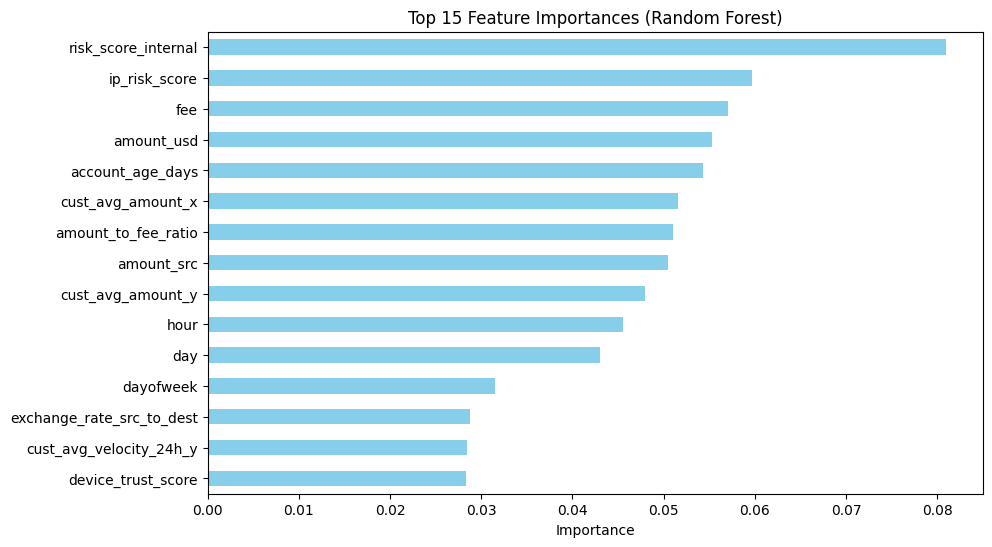

In [49]:
importances = rf_model.feature_importances_
# Match with feature names
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names)

# Sort and take top 15
top_feats = feat_importances.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(10,6))
top_feats.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()  # Highest importance on top
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [50]:
## Train the lgb_model
# Compute scale_pos_weight for LightGBM
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    scale_pos_weight=scale_pos_weight)

In [51]:
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:,1]

print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("LightGBM ROC-AUC:", roc_auc_score(y_test, y_prob_lgb))

[LightGBM] [Info] Number of positive: 156, number of negative: 7955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1997
[LightGBM] [Info] Number of data points in the train set: 8111, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019233 -> initscore=-3.931700
[LightGBM] [Info] Start training from score -3.931700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

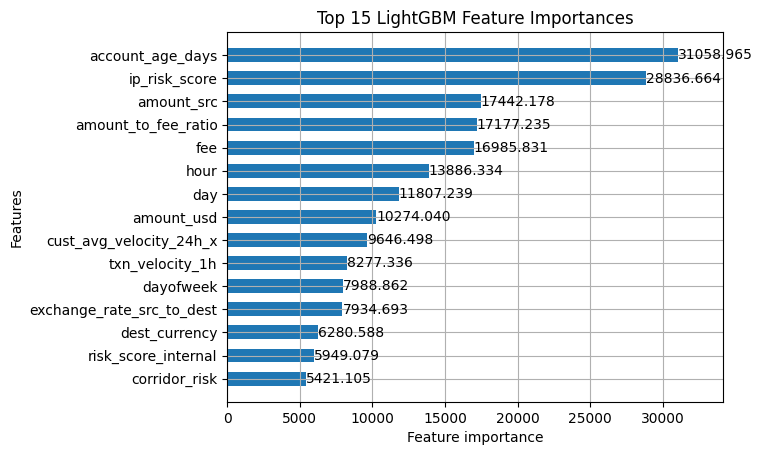

In [52]:

lgb.plot_importance(lgb_model, max_num_features=15, importance_type='gain', height=0.6)
plt.title("Top 15 LightGBM Feature Importances")
plt.show()

## **HYPERPARAMETER TUNNING**

In [53]:
# Initialize model
xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight=(len(y_train[y_train==0])/len(y_train[y_train==1])))

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Use f1-score for scoring since fraud is imbalanced
scorer = make_scorer(f1_score, pos_label=1)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best params:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Best F1-score: 0.1133550469168501


In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

# List of models
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model
}

# Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate
def evaluate_model(model, X_train, y_train, X_test, y_test):
    results = {}

    # Train F1
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results['Train F1'] = f1_score(y_train, y_train_pred)
    results['Test F1'] = f1_score(y_test, y_test_pred)
    results['Train Precision'] = precision_score(y_train, y_train_pred)
    results['Test Precision'] = precision_score(y_test, y_test_pred)
    results['Train Recall'] = recall_score(y_train, y_train_pred)
    results['Test Recall'] = recall_score(y_test, y_test_pred)

    # ROC-AUC
    try:
        y_train_prob = model.predict_proba(X_train)[:,1]
        y_test_prob = model.predict_proba(X_test)[:,1]
        results['Train ROC-AUC'] = roc_auc_score(y_train, y_train_prob)
        results['Test ROC-AUC'] = roc_auc_score(y_test, y_test_prob)
    except:
        results['Train ROC-AUC'] = "NA"
        results['Test ROC-AUC'] = "NA"

    # Cross-validation F1 (stability)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    results['CV Mean F1'] = cv_scores.mean()
    results['CV Std F1'] = cv_scores.std()

    return results

# Evaluate all models
for name, model in models.items():
    print(f"=== {name} ===")
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    for k, v in metrics.items():
        print(f"{k}: {v}")
    print("\n")


=== Random Forest ===
Train F1: 0.23251028806584362
Test F1: 0.09836065573770492
Train Precision: 0.13848039215686275
Test Precision: 0.05853658536585366
Train Recall: 0.7243589743589743
Test Recall: 0.3076923076923077
Train ROC-AUC: 0.9461949427065706
Test ROC-AUC: 0.7390390738807029
CV Mean F1: 0.107236815707808
CV Std F1: 0.025708242176917834


=== XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:48:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:48:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:48:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:48:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:48:07] WARNING: /w

Train F1: 0.975
Test F1: 0.03773584905660377
Train Precision: 0.9512195121951219
Test Precision: 0.07142857142857142
Train Recall: 1.0
Test Recall: 0.02564102564102564
Train ROC-AUC: 1.0
Test ROC-AUC: 0.6890074899124673
CV Mean F1: 0.054909318323952475
CV Std F1: 0.03277048155096936


=== LightGBM ===
[LightGBM] [Info] Number of positive: 156, number of negative: 7955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1997
[LightGBM] [Info] Number of data points in the train set: 8111, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019233 -> initscore=-3.931700
[LightGBM] [Info] Start training from score -3.931700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

**Key Observations:**

**Overfitting:**

XGBoost and LightGBM have extreme overfitting:

Train F1 ~ 0.8–0.93, but Test F1 ~ 0.03–0.04

Train Recall = 1.0, but Test Recall ~ 0.03–0.05

This means they memorize the training data but fail to detect fraud on unseen data.

Random Forest is less overfitted: Test F1 = 0.135 and Test Recall = 0.385, so it’s doing better on actual fraud detection.

**ROC-AUC:**

Random Forest test ROC-AUC = 0.743 → decent discrimination between fraud and non-fraud.

XGBoost and LightGBM have lower test ROC-AUC (~0.63–0.67), worse at distinguishing classes on unseen data.

**Stability (CV)**

Random Forest CV Mean F1 = 0.106, CV Std F1 = 0.02 → more stable than the other two.

XGBoost & LightGBM CV F1 < 0.05 and Std ~0.03 → very unstable.

### Deploy model

In [55]:
import os

# Create a folder named 'fraud_app'
os.makedirs("fraud_app", exist_ok=True)

In [57]:
import joblib

# Save the model in the 'fraud_app' folder
joblib.dump(rf_model, "fraud_app/rf_fraud_model.pkl")


['fraud_app/rf_fraud_model.pkl']

In [58]:
# Install Streamlit and other dependencies
!pip install streamlit pandas scikit-learn joblib

In [60]:
# Import libraries
import streamlit as st
import pandas as pd
import joblib


model = joblib.load("rf_fraud_model.pkl")  # make sure file is in repo root or provide relative path


# Streamlit app code
st.title("💳 Fraud Detection Demo")
st.write("Enter transaction details:")

# Input fields
amount_usd = st.number_input("Transaction Amount (USD)", min_value=0.0, value=100.0)
fee = st.number_input("Transaction Fee", min_value=0.0, value=1.0)
device_trust_score = st.slider("Device Trust Score", 0.0, 1.0, 0.5)
risk_score_internal = st.slider("Internal Risk Score", 0.0, 1.0, 0.5)
account_age_days = st.number_input("Account Age (days)", min_value=0, value=365)
cust_avg_velocity_1h = st.number_input("Customer Avg Transactions Last 1h", min_value=0, value=0)
cust_avg_velocity_24h = st.number_input("Customer Avg Transactions Last 24h", min_value=0, value=0)
cust_avg_amount = st.number_input("Customer Avg Transaction Amount", min_value=0.0, value=100.0)
new_device = st.selectbox("New Device?", [0, 1])
corridor_risk = st.slider("Corridor Risk", 0.0, 1.0, 0.5)
amount_to_ratio_fee = st.number_input("Amount to Fee Ratio", min_value=0.0, value=100.0)
dest_currency = st.text_input("Destination Currency", value="USD")
channel = st.text_input("Transaction Channel", value="online")
ip_country = st.text_input("IP Country", value="US")
day = st.number_input("Day of Week (0=Monday, 6=Sunday)", min_value=0, max_value=6, value=0)

if st.button("Predict Fraud Score"):
    input_df = pd.DataFrame([{
        'amount_usd': amount_usd,
        'fee': fee,
        'device_trust_score': device_trust_score,
        'risk_score_internal': risk_score_internal,
        'account_age_days': account_age_days,
        'cust_avg_velocity_1h': cust_avg_velocity_1h,
        'cust_avg_velocity_24h': cust_avg_velocity_24h,
        'cust_avg_amount': cust_avg_amount,
        'new_device': new_device,
        'corridor_risk': corridor_risk,
        'amount_to_ratio_fee': amount_to_ratio_fee,
        'dest_currency': dest_currency,
        'channel': channel,
        'ip_country': ip_country,
        'day': day
    }])

    score = model.predict_proba(input_df)[:,1][0]
    st.write(f"Fraud Score: **{score:.2f}** (0 = low risk, 1 = high risk)")

2025-12-19 16:51:35.194 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:36.077 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-19 16:51:36.079 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:36.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:36.086 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:36.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:36.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:36.090 Thread 'MainThread': mi

In [61]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)  # Make sure your data is ready

# Save the fitted model
joblib.dump(model, "rf_fraud_model.pkl")


['rf_fraud_model.pkl']

In [62]:
import streamlit as st
try:
    model = joblib.load(model_path)
except Exception as e:
    st.error(f"Error loading model: {e}")
    st.stop()

2025-12-19 16:51:44.646 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:44.647 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:44.648 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 16:51:44.649 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [63]:
%%writefile fraud_app/requirements.txt
streamlit
scikit-learn
numpy
pandas
joblib
xgboost
lightgbm


Overwriting fraud_app/requirements.txt


In [66]:
# Check status
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [67]:
!git remote add origin https://github.com/aderemi1224/fraud_detection_app


In [68]:
!git remote -v

origin	https://github.com/aderemi1224/fraud_detection_app (fetch)
origin	https://github.com/aderemi1224/fraud_detection_app (push)


In [69]:
!git add .
!git commit -m "Initial commit: added Random Forest model and Streamlit app"


Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@bd2a9e17c464.(none)')


In [70]:
!git config --global user.name "Aderemi Oluwadamilola"
!git config --global user.email "aderemioluwadamiola@gmail.com"


In [71]:
!git add .
!git commit -m "Initial commit: added Random Forest model and Streamlit app"

[master (root-commit) 52cf66d] Initial commit: added Random Forest model and Streamlit app
 27 files changed, 81452 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.12.11/14.33.40.102128.log
 create mode 100644 .config/logs/2025.12.11/14.34.12.303029.log
 create mode 100644 .config/logs/2025.12.11/14.34.22.298248.log
 create mode 100644 .config/logs/2025.12.11/14.34.28.289959.log
 create mode 100644 .config/logs/2025.12.11/14.34.38.212031.log
 create mode 100644 .config/logs/2025.12.11/14.34.39.029902.log
 create mode 1

In [72]:
# Remove sample_data files from Git (keep locally)
!git rm --cached "sample_data/README.md"
!git rm --cached "sample_data/anscombe.json"
!git rm --cached "sample_data/california_housing_test.csv"
!git rm --cached "sample_data/california_housing_train.csv"
!git rm --cached "sample_data/mnist_test.csv"
!git rm --cached "sample_data/mnist_train_small.csv"

# Remove unwanted CSV files from Git entirely
!git rm "Cleaned_nova_pay_data (1).csv"
!git rm "Cleaned_nova_pay_data (2).csv"



rm 'sample_data/README.md'
rm 'sample_data/anscombe.json'
rm 'sample_data/california_housing_test.csv'
rm 'sample_data/california_housing_train.csv'
rm 'sample_data/mnist_test.csv'
rm 'sample_data/mnist_train_small.csv'
rm 'Cleaned_nova_pay_data (1).csv'
rm 'Cleaned_nova_pay_data (2).csv'


In [74]:
# Remove all extra CSVs and zip files
!git rm --cached "fraud_app.zip"

# Remove any leftover sample_data folder
!git rm -r --cached sample_data/


fatal: pathspec 'fraud_app.zip' did not match any files
fatal: pathspec 'sample_data/' did not match any files
